# A computationally efficient nonparametric approach for changepoint detection
# https://arxiv.org/abs/1602.01254 

In [50]:
import numpy as np
import pandas as pd
from collections import deque

In [46]:
def generate_synthetic_data(changepoints, segment_means, length=1000):
    data = []
    start = 0
    for cp, mean in zip(changepoints, segment_means):
        segment = np.random.normal(loc=mean, scale=1, size=cp - start)
        data.extend(segment)
        start = cp
    data.extend(np.random.normal(loc=segment_means[-1], scale=1, size=length - start))
    return np.array(data)

def normalize(data):
    return (data - np.mean(data)) / np.std(data)

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')



In [3]:
# Or generate synthetic data
data = generate_synthetic_data(changepoints=[200, 400, 600], segment_means=[5, 10, 5, 0])

# Normalize the data
normalized_data = normalize(data)

# Apply smoothing
smoothed_data = moving_average(normalized_data, window_size=5)

In [4]:
def log_likelihood(segment):
    n = len(segment)
    mean = np.mean(segment)
    variance = np.var(segment)
    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * n * np.log(variance) - 0.5 * np.sum((segment - mean) ** 2) / variance
    return log_likelihood


def penalized_cost(segment, penalty_factor=1):
    n = len(segment)
    p = 2  # Number of parameters for Gaussian distribution
    penalty = penalty_factor * (p / 2) * np.log(n)
    cost = -log_likelihood(segment) + penalty
    return cost

In [37]:
def initialize_pelt(data_length, penalty_factor):
    costs = [0] * (data_length + 1)  # Costs for each segmentation point
    segments = [0] * (data_length + 1)  # Segment starting points
    candidates = [0]  # Candidate changepoints
    return costs, segments, candidates


def pelt_algorithm(data, penalty_factor=1):
    data_length = len(data)
    costs, segments, candidates = initialize_pelt(data_length, penalty_factor)

    for t in range(1, data_length + 1):
        min_cost = float('inf')
        min_candidate = 0

        # Iterate through candidate changepoints and find the one that minimizes the cost
        for candidate in candidates:
            segment = data[candidate:t]
            cost = penalized_cost(segment, penalty_factor) + costs[candidate]
            if cost < min_cost:
                min_cost = cost
                min_candidate = candidate

        costs[t] = min_cost
        segments[t] = min_candidate

        # Update candidates based on pruning strategy
        candidates = pruning_strategy(candidates, costs, t)

    return extract_changepoints(segments, costs)


# def pelt_algorithm(data, penalty_factor=1):
#     data_length = len(data)
#     costs, segments, candidates = initialize_pelt(data_length, penalty_factor)

#     for t in range(1, data_length + 1):
#         min_cost = float('inf')
#         min_candidate = 0
#         current_candidates = list(range(t))  # Define candidates up to current time t

#         # Iterate through candidate changepoints and find the one that minimizes the cost
#         for candidate in current_candidates:
#             segment = data[candidate:t]
#             cost = penalized_cost(segment, penalty_factor) + costs[candidate]
#             if cost < min_cost:
#                 min_cost = cost
#                 min_candidate = candidate

#         costs[t] = min_cost
#         segments[t] = min_candidate

#         # Update candidates based on pruning strategy
#         candidates = pruning_strategy(current_candidates, costs, t, data, penalty_factor)


#     return extract_changepoints(segments, costs)



def extract_changepoints(segments, costs):
    changepoints = []
    t = len(segments) - 1
    while t > 0:
        changepoint = segments[t]
        changepoints.append(changepoint)
        t = changepoint
    return sorted(changepoints)


# def extract_changepoints(segments, costs):
#     changepoints = []
#     t = len(segments) - 1
#     while t > 0:
#         changepoint = segments[t]
#         changepoints.append(changepoint)
#         t = changepoint
#         segments[t] = 0  # Setting the segment at this changepoint to 0 to avoid looping back to the same point
#     return sorted(changepoints)



In [29]:
def pruning_strategy(candidates, costs, t):
    pruned_candidates = [0]  # Always keep the first candidate (start of the data)

    # Iterate through the candidates in reverse order
    for i in reversed(candidates[1:]):
        # If the cost of candidate i is less than the cost of the last pruned candidate,
        # add it to the pruned candidates
        if costs[i] < costs[pruned_candidates[-1]]:
            pruned_candidates.append(i)

    return pruned_candidates[::-1]  # Return the pruned candidates in ascending order


# def pruning_strategy(candidates, costs, t):
#     pruned_candidates = []
    
#     for i in range(len(candidates) - 1, -1, -1):
#         candidate = candidates[i]
#         if i == len(candidates) - 1 or costs[candidate] + penalized_cost(data[candidate:t]) < costs[pruned_candidates[-1]] + penalized_cost(data[pruned_candidates[-1]:t]):
#             pruned_candidates.append(candidate)

#     return pruned_candidates[::-1]  # Return the pruned candidates in ascending order



# def pruning_strategy(candidates, costs, t, data, penalty_factor):
#     pruned_candidates = candidates.copy()
    
#     # Simple pruning logic
#     for i in reversed(range(len(candidates) - 1)):
#         segment1 = data[candidates[i]:t]
#         segment2 = data[candidates[i+1]:t]
#         cost1 = penalized_cost(segment1, penalty_factor)
#         cost2 = penalized_cost(segment2, penalty_factor)
        
#         if cost1 > cost2:
#             pruned_candidates.remove(candidates[i])
            
#     return pruned_candidates


In [30]:
def define_penalty_range(start, end, step):
    return np.arange(start, end, step)


def apply_pelt_with_crops(data, penalty_range):
    all_changepoints = {}
    for penalty in penalty_range:
        changepoints = pelt_algorithm(data, penalty_factor=penalty)
        all_changepoints[penalty] = changepoints
    return all_changepoints


/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_60753/554445297.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({


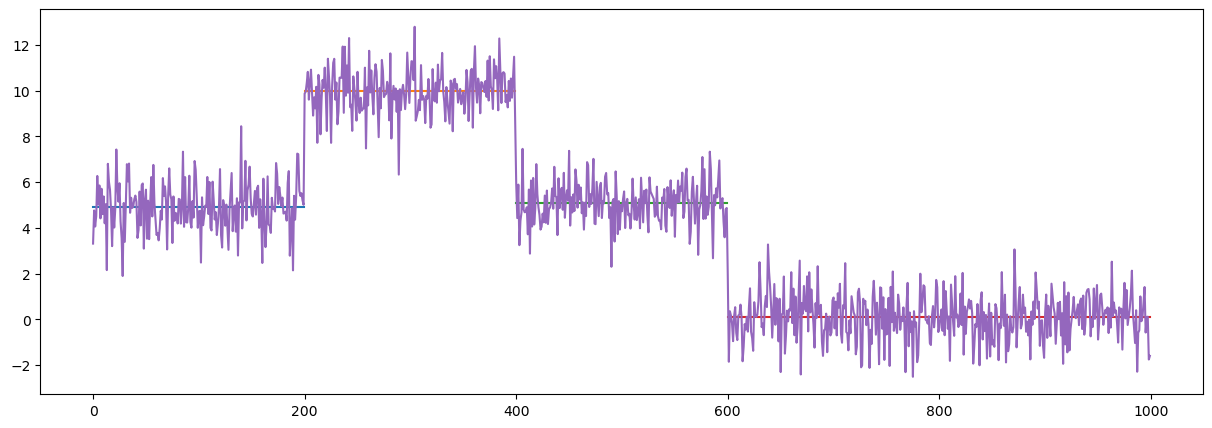

[199, 399, 599]

In [48]:
# Defining the pelt function
def pelt(data, **kwargs):
    # Pre-processing 
    df = pd.DataFrame(data) 
    df['squared'] = np.square(df[0]) 
    df['cumsum'] = np.cumsum(df[0], axis=0) 
    df['cumsumsquared'] = np.cumsum(df['squared'], axis=0) 
    df['diviseur'] = [x for x in range(1,len(df)+1)] 
    df['mean'] = df['cumsum'] / df['diviseur'] 
    df['meansquared'] = np.square(df['mean']) 
    df = df.append({ 
        0:0, 
        'cumsum':0, 
        'cumsumsquared':0, 
        'diviseur':0, 
        'mean':0, 
        'meansquared':0, 
        'squared':0}, ignore_index=True) 

    # Penalty 
    if 'penalty' in kwargs: 
        B = kwargs['penalty'] 
    else: 
        B = 2 * np.log(len(data)) 

    # Initialization 
    Q = [-B] # Actual cost 
    CP = [-1] # Last segment position 
    T = [x for x in range(0,len(data))] # Authorized positions 

    # Parse the data 
    for pos in range(0,len(data)): 
        costs = []
        min_cost_val_temp = float("inf")
        min_cost_pos_temp = -1

        # Parse all the Yi:pos that are still available 
        for i in T: 
            if i > pos: 
                break 

            # Square sum minus N times the square mean 
            sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[i-1] 
            n = pos - i + 1 
            ms = (data[i:pos+1].mean())**2 
            C = sos - (n*ms) 

            # Cost test 
            temp_cost = Q[i] + C + B 
            if min_cost_val_temp > temp_cost: 
                min_cost_val_temp = temp_cost 
                min_cost_val_pos = i 

        # Push the smallest cost 
        Q.append(min_cost_val_temp) 

        # Push the position 
        CP.append(min_cost_val_pos) 

        # Prunning 
        for i in T: 
            if i >= pos: 
                break 

            iplusone = i+1 
            # Square sum minus N times the square mean 
            sos = df['cumsumsquared'].iloc[pos] - df['cumsumsquared'].iloc[iplusone-1] 
            n = pos - iplusone + 1 
            ms = (data[iplusone:pos+1].mean())**2 
            C = sos - (n*ms) 

            if (Q[i] + C > Q[pos]): 
                T.remove(i) 

    return CP

# Defining the backtracking function
def backtracking(CP):
    n = len(CP)-1
    segments = []
    changepoint = CP[n]
    while changepoint > 0:
        segments.append(changepoint-1)
        changepoint = CP[changepoint]
    segments.reverse()
    return segments

# Defining the plot_segments function
def plot_segments(data, segments, ylim=False):
    fig, ax = plt.subplots(figsize=(15,5))
    start = 0
    for end in segments:
        mean = data[start:end+1].sum() / len(data[start:end+1])
        plt.plot((start, end), (mean, mean))
        start = end+1
    end = len(data)-1
    mean = data[start:end+1].sum() / len(data[start:end+1])
    plt.plot((start, end), (mean, mean))
    if ylim != False:
        plt.ylim(ylim)
    plt.plot(data)
    plt.show()

# Running the defined PELT algorithm on the synthetic test data
changepoint_positions = pelt(data)

# Applying backtracking to the changepoint positions to get the segments
detected_segments = backtracking(changepoint_positions)

# Plotting the detected segments
plot_segments(data, detected_segments)

# Returning the detected segments for further examination
detected_segments


/var/folders/_8/pmt00p0n2zsgw2rvt0djf05m0000gp/T/ipykernel_60753/3013689084.py:38: RuntimeWarning: invalid value encountered in scalar divide
  segment_mean_next = (cumsum[pos] - (cumsum[iplusone - 1] if iplusone > 0 else 0)) / segment_n_next


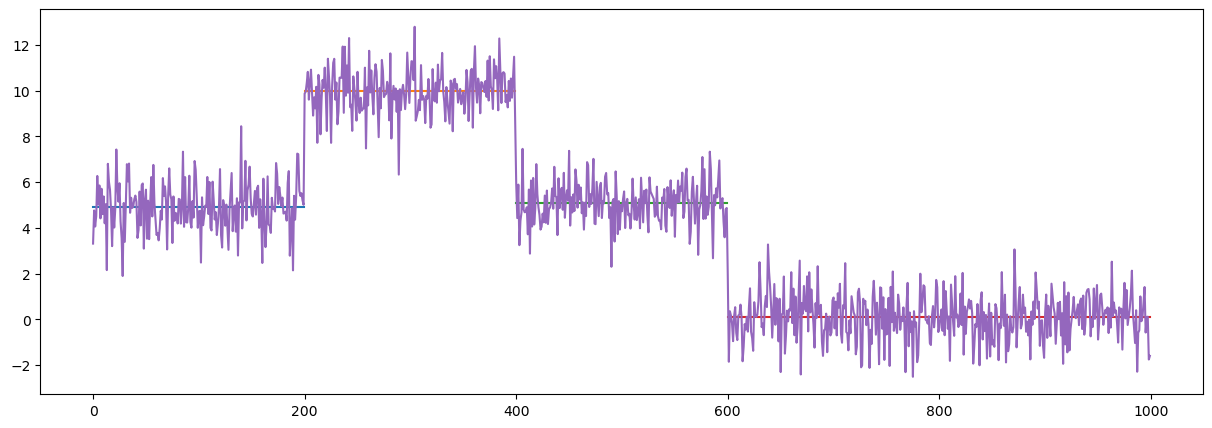

[199, 399, 599]

In [53]:
# Highly optimized PELT function
def highly_optimized_pelt(data, penalty=None):
    n = len(data)
    if penalty is None:
        penalty = 2 * np.log(n)

    # Pre-processing using NumPy (vectorized)
    cumsum = np.cumsum(data)
    cumsum_squared = np.cumsum(np.square(data))

    # Initialization
    Q = np.full(n + 1, np.inf)
    Q[0] = -penalty
    CP = np.zeros(n + 1, dtype=int) - 1
    T = deque(range(n))

    # Parse the data
    for pos in range(n):
        to_remove = []
        for i in T:
            if i > pos:
                break
            prev_cumsum = cumsum[i - 1] if i > 0 else 0
            prev_cumsum_squared = cumsum_squared[i - 1] if i > 0 else 0

            segment_n = pos - i + 1
            segment_mean = (cumsum[pos] - prev_cumsum) / segment_n
            sos = cumsum_squared[pos] - prev_cumsum_squared
            C = sos - (segment_n * segment_mean ** 2)
            temp_cost = Q[i] + C + penalty
            if Q[pos + 1] > temp_cost:
                Q[pos + 1] = temp_cost
                CP[pos + 1] = i

            # Pruning within the same loop to minimize redundant calculations
            iplusone = i + 1
            segment_n_next = pos - iplusone + 1
            segment_mean_next = (cumsum[pos] - (cumsum[iplusone - 1] if iplusone > 0 else 0)) / segment_n_next
            sos_next = cumsum_squared[pos] - (cumsum_squared[iplusone - 1] if iplusone > 0 else 0)
            C_next = sos_next - (segment_n_next * segment_mean_next ** 2)
            if Q[i] + C_next > Q[pos + 1]:
                to_remove.append(i)
        for i in to_remove:
            T.remove(i)

    return CP

# Testing the highly optimized PELT algorithm on the synthetic test data
highly_optimized_changepoint_positions = highly_optimized_pelt(data)

# Applying backtracking to the highly optimized changepoint positions to get the segments
highly_optimized_detected_segments = backtracking(highly_optimized_changepoint_positions)

# Plotting the detected segments using the highly optimized code
plot_segments(data, highly_optimized_detected_segments)

# Returning the detected segments for further examination
highly_optimized_detected_segments


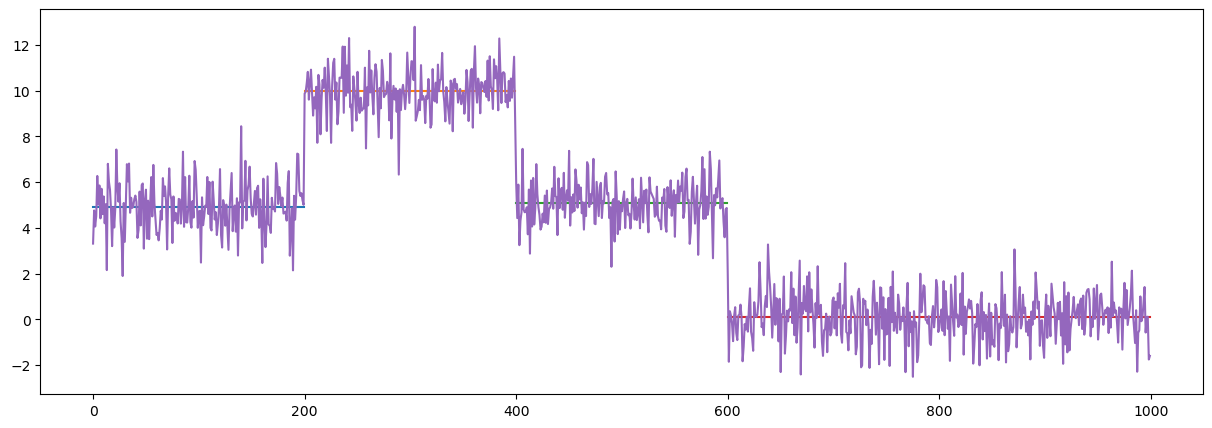

[199, 399, 599]

In [54]:
# Final optimization of the PELT function
def final_optimized_pelt(data, penalty=None):
    n = len(data)
    if penalty is None:
        penalty = 2 * np.log(n)

    # Pre-processing using NumPy (vectorized)
    cumsum = np.cumsum(data)
    cumsum_squared = np.cumsum(np.square(data))

    # Initialization
    Q = np.full(n + 1, np.inf)
    Q[0] = -penalty
    CP = np.zeros(n + 1, dtype=int) - 1
    T = deque(range(n))

    # Parse the data
    for pos in range(n):
        to_remove = []
        for i in T:
            if i > pos:
                break
            prev_cumsum = cumsum[i - 1] if i > 0 else 0
            prev_cumsum_squared = cumsum_squared[i - 1] if i > 0 else 0

            segment_n = pos - i + 1
            segment_mean = (cumsum[pos] - prev_cumsum) / segment_n
            sos = cumsum_squared[pos] - prev_cumsum_squared
            C = sos - (segment_n * segment_mean ** 2)
            temp_cost = Q[i] + C + penalty
            if Q[pos + 1] > temp_cost:
                Q[pos + 1] = temp_cost
                CP[pos + 1] = i

            # Pruning within the same loop with division by zero handling
            iplusone = i + 1
            segment_n_next = pos - iplusone + 1
            if segment_n_next > 0:
                segment_mean_next = (cumsum[pos] - (cumsum[iplusone - 1] if iplusone > 0 else 0)) / segment_n_next
                sos_next = cumsum_squared[pos] - (cumsum_squared[iplusone - 1] if iplusone > 0 else 0)
                C_next = sos_next - (segment_n_next * segment_mean_next ** 2)
                if Q[i] + C_next > Q[pos + 1]:
                    to_remove.append(i)
        for i in to_remove:
            T.remove(i)

    return CP

# Testing the final optimized PELT algorithm on the synthetic test data
final_optimized_changepoint_positions = final_optimized_pelt(data)

# Applying backtracking to the final optimized changepoint positions to get the segments
final_optimized_detected_segments = backtracking(final_optimized_changepoint_positions)

# Plotting the detected segments using the final optimized code
plot_segments(data, final_optimized_detected_segments)

# Returning the detected segments for further examination
final_optimized_detected_segments